In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.spatial import distance
from tqdm import tqdm

import spektral
import matplotlib.pyplot as plt

from spektral.layers.convolutional import GraphSageConv, GCNConv, EdgeConv, ECCConv
from spektral.layers.pooling import GlobalAttentionPool
from spektral import utils

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Flatten, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.optimizers import Adam

### Load prepared data

In [22]:
source = '/media/storage_3/abiricz/Mobilcell/TimeIntervalGraphs_spektral/'
#source = '/media/Data_storage/Mobilcell/TimeIntervalGraphs_spektral/'
source_pol = '/media/storage_3/abiricz/Mobilcell/DayPolygonData/'
files = np.array( sorted([ i for i in os.listdir(source) ]) )
files[:10], files.shape

(array(['graphNN_samples_series-3_target-1_20181203.npz',
        'graphNN_samples_series-3_target-1_20181204.npz',
        'graphNN_samples_series-3_target-1_20181205.npz',
        'graphNN_samples_series-3_target-1_20181206.npz',
        'graphNN_samples_series-3_target-1_20181207.npz',
        'graphNN_samples_series-3_target-1_20181210.npz',
        'graphNN_samples_series-3_target-1_20181211.npz',
        'graphNN_samples_series-3_target-1_20181212.npz',
        'graphNN_samples_series-3_target-1_20181213.npz',
        'graphNN_samples_series-3_target-1_20181214.npz'], dtype='<U46'),
 (20,))

In [23]:
dates = np.unique( [ j.split('_')[4][:-4] for j in files ] )
dates

array(['20181203', '20181204', '20181205', '20181206', '20181207',
       '20181210', '20181211', '20181212', '20181213', '20181214',
       '20181217', '20181218', '20181219', '20181220', '20181221',
       '20181224', '20181225', '20181226', '20181227', '20181228'],
      dtype='<U8')

#### Create adjacency matrix based on distance

In [24]:
tower_info = pd.read_csv( source_pol+'fixed_merged-40_tower_locations.csv' ) ## CHANGED
sort_idx = np.argsort( tower_info.tower_id.values )
tower_info = tower_info.iloc[ sort_idx ]
tower_info.reset_index(inplace=True)

coords = np.unique( tower_info.iloc[:,2:], axis=0 )[:,1:]
coords.shape

(8622, 2)

#### Adjacency matrix as decaying distance matrix

In [5]:
adj_mat = np.exp( -distance.cdist( coords, coords, 'euclidean' ) / 20000 )
adj_mat = adj_mat*(1*adj_mat < 1e-3) # zero at 140 km away

### Ideas:
- node prediction: 
    - use node features
    
    
- link prediction the same way using line graph

- try spektral edge conditioned conv to predict node features 
    - stack 3 consequtive steps as node and edge feature sets

### Data loader 

In [6]:
def load_data(coords, daynum):
    loaded = np.load( source+'graphNN_samples_series-3_target-1_'+dates[daynum]+'.npz' )
    nfs = loaded['nf']
    ef_mats = loaded['ef_mat']
    nf_targets = loaded['nf_target']
    node_filt = loaded['filt']
    
    adj_mat = np.exp( -distance.cdist( coords, coords, 'euclidean' ) / 20000 )
    adj_mat = adj_mat*(1*adj_mat < 1e-3) # zero at 140 km away
    adj_mat = adj_mat[ np.ix_(node_filt, node_filt) ]
    adj_mat = utils.normalized_laplacian(adj_mat)
    adj_mat = np.repeat( np.expand_dims(adj_mat, 0), 21, 0 )
    
    
    return adj_mat, nfs, ef_mats, nf_targets

In [7]:
adj_mat, nfs, ef_mats, nf_targets = load_data(coords, 1)

In [10]:
adj_mat.shape, nfs.shape, nf_targets.shape, ef_mats.shape

((21, 4002, 4002), (21, 4002, 3), (21, 4002, 1), (21, 4002, 4002, 3))

### ML

In [11]:
# Parameters
N = nfs.shape[-2]          # Number of nodes in the graphs
F = nfs.shape[-1]          # Node features dimensionality
S = ef_mats.shape[-1]      # Edge feature dim
#N_line = nf_train_line.shape[-2]          # Number of nodes in the graphs
#F_line = nf_train_line.shape[-1]          # Node features dimensionality
# Dimensionalities of the targets
n_out = nf_targets.shape[-2]
learning_rate = 1e-4      # Learning rate for SGD
epochs = 50              # Number of training epochs
batch_size = 7         # Batch size
es_patience = 500           # Patience fot early stopping

In [12]:
# Model definition
nf_in = Input(shape=(N, F))
adj_in = Input(shape=(N, N))

gc0 = GCNConv( 256, activation='relu')([nf_in, adj_in])
gc0 = GCNConv( 128, activation='relu')([gc0, adj_in])
gc0 = GCNConv( 64, activation='relu')([gc0, adj_in])
gc0 = GCNConv( 1, activation='relu')([gc0, adj_in])

outp = Flatten()(gc0)
#outp = GlobalAttentionPool()(gc0)

In [13]:
# Build model
model = Model( inputs=[nf_in, adj_in], outputs=outp )
#model = multi_gpu_model(model, 2)
optimizer = Adam( lr=learning_rate, amsgrad=True, decay=1e-6 )
model.compile( optimizer=optimizer, loss='mae' )
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4002, 3)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4002, 4002)] 0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 4002, 256)    1024        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gcn_conv_1 (GCNConv)            (None, 4002, 128)    32896       gcn_conv[0][0]        

In [14]:
# Train model
# [nf_in, adj_in, ef_in]
hists = []
for n in range(10):
    adj_mat, nfs, ef_mats, nf_targets = load_data(coords, n)
    print(adj_mat.shape, nfs.shape, ef_mats.shape, nf_targets.shape)
    history = model.fit([nfs, adj_mat],
              nf_targets,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=epochs)
    hists.append(history)

(21, 4002, 4002) (21, 4002, 3) (21, 4002, 4002, 3) (21, 4002, 1)
Epoch 1/50
3/3 [==============================] - 1s 188ms/step - loss: 843.5962 - val_loss: 318.5927
Epoch 2/50
3/3 [==============================] - 0s 106ms/step - loss: 826.8522 - val_loss: 312.0324
Epoch 3/50
3/3 [==============================] - 0s 106ms/step - loss: 812.8977 - val_loss: 310.0162
Epoch 4/50
3/3 [==============================] - 0s 103ms/step - loss: 803.4058 - val_loss: 310.9930
Epoch 5/50
3/3 [==============================] - 0s 97ms/step - loss: 797.0941 - val_loss: 313.0874
Epoch 6/50
3/3 [==============================] - 0s 99ms/step - loss: 793.4870 - val_loss: 314.9343
Epoch 7/50
3/3 [==============================] - 0s 108ms/step - loss: 790.6097 - val_loss: 315.3232
Epoch 8/50
3/3 [==============================] - 0s 101ms/step - loss: 785.9575 - val_loss: 312.1759
Epoch 9/50
3/3 [==============================] - 0s 112ms/step - loss: 777.7834 - val_loss: 305.9792
Epoch 10/50
3/3 [==

3/3 [==============================] - 0s 116ms/step - loss: 410.9335 - val_loss: 195.8906
Epoch 30/50
3/3 [==============================] - 0s 115ms/step - loss: 409.8548 - val_loss: 193.8063
Epoch 31/50
3/3 [==============================] - 0s 103ms/step - loss: 408.8614 - val_loss: 192.4945
Epoch 32/50
3/3 [==============================] - 0s 102ms/step - loss: 407.9197 - val_loss: 190.9763
Epoch 33/50
3/3 [==============================] - 0s 106ms/step - loss: 406.9252 - val_loss: 190.1917
Epoch 34/50
3/3 [==============================] - 0s 109ms/step - loss: 405.7702 - val_loss: 188.3261
Epoch 35/50
3/3 [==============================] - 0s 113ms/step - loss: 404.7057 - val_loss: 186.3533
Epoch 36/50
3/3 [==============================] - 0s 105ms/step - loss: 403.8686 - val_loss: 184.5545
Epoch 37/50
3/3 [==============================] - 0s 113ms/step - loss: 402.9430 - val_loss: 182.8820
Epoch 38/50
3/3 [==============================] - 0s 95ms/step - loss: 401.8605 - va

3/3 [==============================] - 0s 105ms/step - loss: 356.3013 - val_loss: 138.6190
Epoch 8/50
3/3 [==============================] - 0s 107ms/step - loss: 355.9980 - val_loss: 137.5988
Epoch 9/50
3/3 [==============================] - 0s 101ms/step - loss: 355.4422 - val_loss: 136.4297
Epoch 10/50
3/3 [==============================] - 0s 96ms/step - loss: 354.2892 - val_loss: 136.6461
Epoch 11/50
3/3 [==============================] - 0s 103ms/step - loss: 353.7020 - val_loss: 136.8738
Epoch 12/50
3/3 [==============================] - 0s 114ms/step - loss: 353.2203 - val_loss: 137.5611
Epoch 13/50
3/3 [==============================] - 0s 106ms/step - loss: 352.4129 - val_loss: 137.9615
Epoch 14/50
3/3 [==============================] - 0s 105ms/step - loss: 351.8704 - val_loss: 137.9688
Epoch 15/50
3/3 [==============================] - 0s 117ms/step - loss: 351.0925 - val_loss: 136.1145
Epoch 16/50
3/3 [==============================] - 0s 122ms/step - loss: 350.3543 - val_

3/3 [==============================] - 0s 104ms/step - loss: 303.8924 - val_loss: 131.6139
Epoch 37/50
3/3 [==============================] - 0s 104ms/step - loss: 303.1842 - val_loss: 130.9293
Epoch 38/50
3/3 [==============================] - 0s 104ms/step - loss: 302.8807 - val_loss: 131.1296
Epoch 39/50
3/3 [==============================] - 0s 101ms/step - loss: 302.0628 - val_loss: 131.4461
Epoch 40/50
3/3 [==============================] - 0s 105ms/step - loss: 301.7022 - val_loss: 130.3696
Epoch 41/50
3/3 [==============================] - 0s 103ms/step - loss: 301.5546 - val_loss: 129.3793
Epoch 42/50
3/3 [==============================] - 0s 118ms/step - loss: 300.6109 - val_loss: 130.4884
Epoch 43/50
3/3 [==============================] - 0s 112ms/step - loss: 300.4496 - val_loss: 132.3218
Epoch 44/50
3/3 [==============================] - 0s 111ms/step - loss: 299.6899 - val_loss: 129.5922
Epoch 45/50
3/3 [==============================] - 0s 114ms/step - loss: 299.1393 - v

3/3 [==============================] - 0s 103ms/step - loss: 267.5740 - val_loss: 118.9916
Epoch 15/50
3/3 [==============================] - 0s 106ms/step - loss: 266.7061 - val_loss: 119.5995
Epoch 16/50
3/3 [==============================] - 0s 109ms/step - loss: 266.1376 - val_loss: 118.6009
Epoch 17/50
3/3 [==============================] - 0s 102ms/step - loss: 265.7982 - val_loss: 119.1431
Epoch 18/50
3/3 [==============================] - 0s 110ms/step - loss: 265.3505 - val_loss: 119.4727
Epoch 19/50
3/3 [==============================] - 0s 101ms/step - loss: 265.0848 - val_loss: 118.5289
Epoch 20/50
3/3 [==============================] - 0s 122ms/step - loss: 264.4543 - val_loss: 119.4568
Epoch 21/50
3/3 [==============================] - 0s 114ms/step - loss: 263.4114 - val_loss: 118.7082
Epoch 22/50
3/3 [==============================] - 0s 117ms/step - loss: 262.8951 - val_loss: 118.5633
Epoch 23/50
3/3 [==============================] - 0s 99ms/step - loss: 262.5688 - va

3/3 [==============================] - 0s 110ms/step - loss: 246.8184 - val_loss: 125.1830
Epoch 44/50
3/3 [==============================] - 0s 107ms/step - loss: 245.4925 - val_loss: 127.6723
Epoch 45/50
3/3 [==============================] - 0s 118ms/step - loss: 245.9033 - val_loss: 125.5901
Epoch 46/50
3/3 [==============================] - 0s 96ms/step - loss: 245.1305 - val_loss: 125.0533
Epoch 47/50
3/3 [==============================] - 0s 104ms/step - loss: 245.3977 - val_loss: 126.8751
Epoch 48/50
3/3 [==============================] - 0s 104ms/step - loss: 245.7388 - val_loss: 126.9432
Epoch 49/50
3/3 [==============================] - 0s 102ms/step - loss: 245.7965 - val_loss: 124.9522
Epoch 50/50
3/3 [==============================] - 0s 84ms/step - loss: 244.7279 - val_loss: 126.8307
(21, 4002, 4002) (21, 4002, 3) (21, 4002, 4002, 3) (21, 4002, 1)
Epoch 1/50
3/3 [==============================] - 1s 184ms/step - loss: 242.2348 - val_loss: 125.5790
Epoch 2/50
3/3 [=======

3/3 [==============================] - 0s 101ms/step - loss: 228.4347 - val_loss: 122.0944
Epoch 22/50
3/3 [==============================] - 0s 104ms/step - loss: 228.9890 - val_loss: 121.0087
Epoch 23/50
3/3 [==============================] - 0s 113ms/step - loss: 228.4230 - val_loss: 121.4324
Epoch 24/50
3/3 [==============================] - 0s 104ms/step - loss: 228.5776 - val_loss: 121.6185
Epoch 25/50
3/3 [==============================] - 0s 102ms/step - loss: 228.4265 - val_loss: 121.2738
Epoch 26/50
3/3 [==============================] - 0s 103ms/step - loss: 228.2992 - val_loss: 120.9438
Epoch 27/50
3/3 [==============================] - 0s 102ms/step - loss: 227.9901 - val_loss: 120.3904
Epoch 28/50
3/3 [==============================] - 0s 104ms/step - loss: 228.2104 - val_loss: 119.9561
Epoch 29/50
3/3 [==============================] - 0s 96ms/step - loss: 227.7718 - val_loss: 121.5707
Epoch 30/50
3/3 [==============================] - 0s 108ms/step - loss: 227.8064 - va

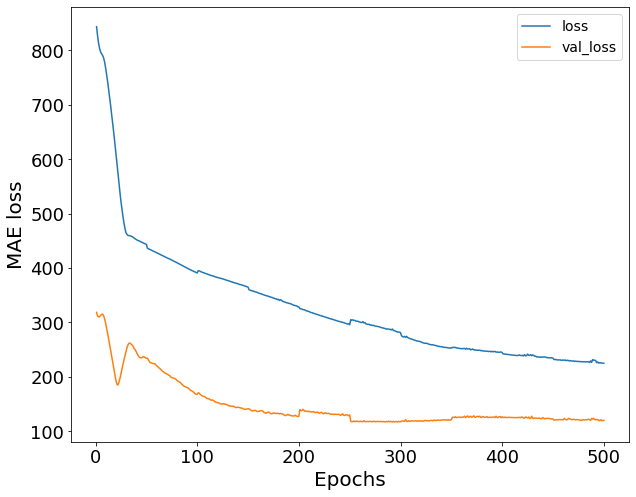

In [16]:
plt.figure( figsize=(10,8) )
plt.plot( np.arange(500)+1, np.concatenate( [ j.history['loss']  for j in hists ] ), label='loss' )
plt.plot( np.arange(500)+1, np.concatenate( [ j.history['val_loss']  for j in hists ] ), label='val_loss' )
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MAE loss', fontsize=20)
plt.tick_params(labelsize=18)
plt.legend( fontsize=14 )

### Evaluation

In [26]:
# Eval model
# [nf_in, adj_in, ef_in]
eval_losses = []
for n in range(10, 20):
    adj_mat, nfs, ef_mats, nf_targets = load_data(coords, n)
    #print(adj_mat.shape, nfs.shape, ef_mats.shape, nf_targets.shape)
    #print(nf_targets[:10])
    eval_loss = model.evaluate([nfs, adj_mat],
              nf_targets,
              batch_size=batch_size )
    eval_losses.append(eval_loss)

3/3 [==============================] - 0s 63ms/step - loss: 196.4802


In [27]:
files[10:20]

array(['graphNN_samples_series-3_target-1_20181217.npz',
       'graphNN_samples_series-3_target-1_20181218.npz',
       'graphNN_samples_series-3_target-1_20181219.npz',
       'graphNN_samples_series-3_target-1_20181220.npz',
       'graphNN_samples_series-3_target-1_20181221.npz',
       'graphNN_samples_series-3_target-1_20181224.npz',
       'graphNN_samples_series-3_target-1_20181225.npz',
       'graphNN_samples_series-3_target-1_20181226.npz',
       'graphNN_samples_series-3_target-1_20181227.npz',
       'graphNN_samples_series-3_target-1_20181228.npz'], dtype='<U46')

In [37]:
preds = model.predict([nfs, adj_mat] )[11]

(array([103., 109., 115., 116., 135., 115.,  99., 107.,  98., 102.,  91.,
         83.,  83.,  63.,  58.,  71.,  46.,  62.,  47.,  47.,  47.,  43.,
         40.,  35.,  46.,  34.,  29.,  42.,  42.,  31.,  29.,  31.,  20.,
         29.,  24.,  31.,  29.,  27.,  23.,  42.,  28.,  20.,  22.,  19.,
         17.,  18.,  16.,  27.,  17.,  19.,  16.,  26.,  10.,  13.,  17.,
         20.,  16.,  15.,  23.,  20.,  17.,  19.,  12.,  13.,  14.,   8.,
         15.,  12.,  10.,  13.,  16.,   9.,  14.,  13.,   5.,   4.,  12.,
          7.,   8.,   7.,   8.,   6.,  12.,  11.,   8.,  11.,  11.,   6.,
          9.]),
 array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
        230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
        360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
        490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
        620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
        750, 760, 770, 780,

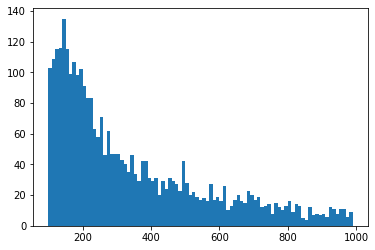

In [47]:
plt.hist( nf_targets[11], bins=np.arange(100,1000,10) )

(array([23., 25., 39., 26., 23., 20., 18., 30., 24., 20., 18., 15., 21.,
        20., 16., 27., 24., 18., 24., 21., 15., 21., 12., 23., 23., 17.,
        15., 13., 19., 12., 16., 10., 21., 18., 14., 20., 18., 21., 13.,
        14., 17., 25., 17.,  8., 18., 15., 12., 11., 11., 10., 12., 13.,
        11.,  5.,  6., 11.,  9.,  6., 11., 16.,  9.,  6.,  9., 12., 12.,
        11.,  5.,  5.,  7., 11.,  4.,  4., 12.,  5.,  7.,  7.,  6.,  7.,
         5.,  7.,  6., 11.,  5.,  5.,  6.,  1.,  8.,  4.,  4.]),
 array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
        230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
        360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
        490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
        620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
        750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
        880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 9

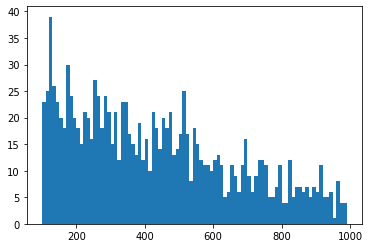

In [48]:
plt.hist(preds, bins=np.arange(100, 1000,10) )